## Import libraries

In [1]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import datasets
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
import csv

## Function definition

In [2]:
def predictSVM(X_train, y_train, X_test, Cp):
#    sclf = SVC(C=Cp, kernel='rbf', gamma=0.01)
    sclf = SVC(C=Cp, kernel='rbf', gamma=0.0005)
    sclf.fit(X_train, y_train)
    return sclf.predict(X_test)

def computeAccuracy(prediction, test):
    return metrics.accuracy_score(test, prediction)

def computeF1(prediction, test):
    return metrics.f1_score(test, prediction)

def ComputeRocAuc(prediction, test):
    return metrics.roc_auc_score(test, prediction)

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Create dataset
First, we import an array *classes* that contains the binary classification (deliberate smile or not) for each video. Then, we import all the feature set. *full.csv* is a CSV that contains 152 features per video: 25 * temporal phase, both for eye features and lip features + age + gender.

In [4]:
classes = []
folder = './features_frontalized_matlab_selected_smoothing25'
with open(folder + '/lip/lip_total/lip_total_features_merged_classes.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    for r in spamreader:
        classes.append(r[0])

features = []
features_path = folder + '/full.csv'
with open(features_path, 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    for r in spamreader:
        features.append(r)

print("number_of_features")
print(len(features[0]))
y = np.array(classes)
X = np.array(features)

# Standardize
scaler = preprocessing.StandardScaler().fit(X)
X_train = scaler.transform(X)

data = [X, y]

number_of_features
152


data is a 2 col matrix.

data[0] (sample n.0) where each element is an array[75] (25 for each phases, concatenated)+ age + gender

data[1] contains the class of each sample in data[0]

## Division and validation

In [5]:
def innerFoldC(X_train, y_train):
    """
    Inner cross validation method to get the correct hyperparameter C
    """
    # Values of C which I have to test
    Cvalues = [1e-4, 1e-03, 1e-02, 1e-01, 1e00, 1e01, 1e02, 1e03]
    innerscoreC = []

    for C in Cvalues:
        # inner 5-fold cross validation on the original training set
        ikf = model_selection.KFold(n_splits=5, random_state=5678, shuffle=True)
        innerf1 = []
        for t_index, v_index in ikf.split(X_train):
            X2_train, X2_test = X_train[t_index], X_train[v_index]
            y2_train, y2_test = y_train[t_index], y_train[v_index]

            ipred = predictSVM(X2_train, y2_train, X2_test, C)
            innerf1.append(computeF1(y2_test, ipred))

        innerscoreC.append(sum(innerf1)/len(innerf1))

    return Cvalues[np.argmax(innerscoreC)]


[evalutation - SVM]

('accuracy', 0.78314691843692619)
('f1', 0.80525033050170669)
Confusion matrix, without normalization
[[414 181]
 [ 87 554]]


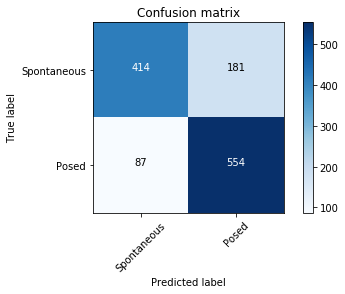

In [6]:
accuracy = {'svm': []}
f1 = {'svm': []}
auc_roc = {'svm': []}

best_c_values = []
best_n_estimators = []
confusion_matrices = []

# Outer cross-validation (10 folds)
skf = model_selection.StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)
for train_index, test_index in skf.split(data[0], data[1]):
    X_train, X_test = data[0][train_index], data[0][test_index]
    y_train, y_test = data[1][train_index], data[1][test_index]
    
    # pick the C that gives the best F1-Score
    bestC = innerFoldC(X_train, y_train)
    best_c_values.append(bestC)

    # Run SVM classifier
    svm_prediction = predictSVM(X_train, y_train, X_test, bestC)
    
    # Evaluate the classification
    confusion_matrices.append(confusion_matrix(y_test, svm_prediction))
    accuracy['svm'].append(computeAccuracy(svm_prediction, y_test))
    f1['svm'].append(computeF1(svm_prediction, y_test))
    auc_roc['svm'].append(ComputeRocAuc(svm_prediction, y_test))
    

resulting_matrix = confusion_matrices[0]
for cm in confusion_matrices[1:]:
    resulting_matrix = np.add(resulting_matrix, cm)
    
print("\n[evalutation - SVM]\n")
print("accuracy", np.mean(accuracy['svm']))
print("f1", np.mean(f1['svm']))

plt.figure()
plot_confusion_matrix(resulting_matrix, ['Spontaneous', 'Posed'])
plt.show()